In [ ]:
!pip install biopython
!pip install pycuda
!apt-get update
!apt-get install -y build-essential dkms
!apt-get install -y nvidia-cuda-toolkit
!pip install cupy-cuda11x
!pip install biopython cupy-cuda11x

!nvcc --version



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=e5c1796261d720dfa378a3fad31668cb58d7db2cefe85e985bb1319f7efe614d
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]


In [ ]:
!pip install pycuda

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
from Bio import SeqIO
import argparse
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import os

def merge_sequences_from_fasta(file_path):
    sequences = []  # List to store all sequences
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return "".join(sequences)

mod = SourceModule("""
__global__ void crear_dotplot(unsigned char *seq1, unsigned char *seq2, unsigned char *dotplot, int len1, int len2) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < len1 && y < len2) {
        if (seq1[x] == seq2[y]) {
            dotplot[x * len2 + y] = 1;
        }
    }
}
""")

crear_dotplot_cuda = mod.get_function("crear_dotplot")

def crear_dotplot(secuencia1, secuencia2):
    codigos_secuencia1 = np.frombuffer(secuencia1.encode(), dtype=np.uint8)
    codigos_secuencia2 = np.frombuffer(secuencia2.encode(), dtype=np.uint8)

    len1 = len(codigos_secuencia1)
    len2 = len(codigos_secuencia2)

    dotplot = np.zeros((len1, len2), dtype=np.uint8)

    threads_per_block = (32, 32, 1)
    blocks_per_grid_x = int(np.ceil(len1 / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(len2 / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, 1)

    # print(f"Threads per block: {threads_per_block}")
    # print(f"Blocks per grid: {blocks_per_grid}")

    try:
        crear_dotplot_cuda(
            drv.In(codigos_secuencia1),
            drv.In(codigos_secuencia2),
            drv.Out(dotplot),
            np.int32(len1),
            np.int32(len2),
            block=threads_per_block,
            grid=blocks_per_grid
        )
        drv.Context.synchronize()
    except drv.LogicError as e:
        print(f"Error en CUDA: {e}")
        raise

    return dotplot

def calcular_peso_matriz(matriz):
    bytes_matriz = sys.getsizeof(matriz)
    megabytes_matriz = bytes_matriz / (1024 ** 2)
    return megabytes_matriz

def draw_dotplot(matrix, fig_name='dotplot.svg'):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='gray', aspect='auto')
    plt.ylabel("Secuencia 1")
    plt.xlabel("Secuencia 2")
    plt.savefig(fig_name)

if __name__ == '__main__':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Cambia estas rutas a las rutas correctas de tus archivos en Google Drive
    file1 = '/content/drive/MyDrive/Datos/E_coli.fna'
    file2 = '/content/drive/MyDrive/Datos/Salmonella.fna'
    limite = 100000  # Reduce the limit to debug
    output = '/content/drive/MyDrive/Datos/output.png'
    block_size = 10000  # Tamaño del bloque

    # Verificar si los archivos existen antes de proceder
    if not os.path.exists(file1):
        raise FileNotFoundError(f"El archivo {file1} no existe.")
    if not os.path.exists(file2):
        raise FileNotFoundError(f"El archivo {file2} no existe.")

    print(f"Ruta del archivo 1: {file1}")
    print(f"Ruta del archivo 2: {file2}")

    parser = argparse.ArgumentParser(description='Mi Aplicación CUDA')
    parser.add_argument('--file1', type=str, help='Ruta del archivo 1')
    parser.add_argument('--file2', type=str, help='Ruta del archivo 2')
    parser.add_argument('--limite', type=int, help='Número máximo de bases a procesar')
    parser.add_argument('--output', type=str, help='Archivo de salida para la imagen')
    args, unknown = parser.parse_known_args()

    # Asegurarse de usar las rutas correctas
    file1 = file1 if file1 else args.file1
    file2 = file2 if file2 else args.file2
    limite = limite if limite else args.limite
    output = output if output else args.output

    # Verificar nuevamente las rutas
    print(f"Procesando archivo 1: {file1}")
    print(f"Procesando archivo 2: {file2}")

    secuencia1 = merge_sequences_from_fasta(file1)[:limite]
    secuencia2 = merge_sequences_from_fasta(file1)[:limite]

    print(f"Tamaño de secuencia 1: {len(secuencia1)}")
    print(f"Tamaño de secuencia 2: {len(secuencia2)}")

    dotplot_final = np.zeros((len(secuencia1), len(secuencia2)), dtype=np.uint8)

    inicio_tiempo = time.time()

    for i in range(0, len(secuencia1), block_size):
        for j in range(0, len(secuencia2), block_size):
            sec1_block = secuencia1[i:i + block_size]
            sec2_block = secuencia2[j:j + block_size]

            dotplot_block = crear_dotplot(sec1_block, sec2_block)

            dotplot_final[i:i + block_size, j:j + block_size] = dotplot_block

    fin_tiempo = time.time()

    preview_size = min(10000, len(secuencia1), len(secuencia2))
    dotplot_preview = dotplot_final[:preview_size, :preview_size]
    plt.imshow(dotplot_preview, cmap='gray')
    plt.title('Dotplot')
    plt.xlabel('Secuencia 2')
    plt.ylabel('Secuencia 1')
    #plt.savefig(output)
    # print("dot completo")
    # draw_dotplot(dotplot_preview, output)
    print("dot 500")
    draw_dotplot(dotplot_preview[:500, :500])

    tiempo_ejecucion = fin_tiempo - inicio_tiempo

    print("El código se ejecutó en:", tiempo_ejecucion, "segundos")
    print("El tamaño de la matriz es:", dotplot_final.shape)
    print("La matriz resultado tiene un tamaño de " + str(calcular_peso_matriz(dotplot_final)) + " Mb")


RuntimeError: cuInit failed: no CUDA-capable device is detected

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import argparse
import os

def merge_sequences_from_fasta(file_path):
    sequences = []  # List to store all sequences
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return "".join(sequences)

def needleman_wunsch(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2)
    best_alignment = alignments[0]
    score = best_alignment[2]
    return score, len(seq1), best_alignment

def calcular_similitud(seq1, seq2):
    score, length, alignment = needleman_wunsch(seq1, seq2)
    similitud = (score / length) * 100
    return similitud, alignment

def draw_dotplot(matrix, fig_name='dotplot.svg'):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='gray', aspect='auto')
    plt.ylabel("Secuencia 1")
    plt.xlabel("Secuencia 2")
    plt.savefig(fig_name)
    plt.close()

if __name__ == '__main__':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Cambia estas rutas a las rutas correctas de tus archivos en Google Drive
    file1 = '/content/drive/MyDrive/Datos/E_coli.fna'
    file2 = '/content/drive/MyDrive/Datos/Salmonella.fna'  # Use the same file to check similarity
    limite = 10000  # Reduce the limit to debug
    output = '/content/drive/MyDrive/Datos/output.png'

    if not os.path.exists(file1):
        raise FileNotFoundError(f"El archivo {file1} no existe.")
    if not os.path.exists(file2):
        raise FileNotFoundError(f"El archivo {file2} no existe.")

    print(f"Ruta del archivo 1: {file1}")
    print(f"Ruta del archivo 2: {file2}")

    parser = argparse.ArgumentParser(description='Mi Aplicación CUDA')
    parser.add_argument('--file1', type=str, help='Ruta del archivo 1')
    parser.add_argument('--file2', type=str, help='Ruta del archivo 2')
    parser.add_argument('--limite', type=int, help='Número máximo de bases a procesar')
    parser.add_argument('--output', type=str, help='Archivo de salida para la imagen')
    args, unknown = parser.parse_known_args()

    # Asegurarse de usar las rutas correctas
    file1 = file1 if file1 else args.file1
    file2 = file2 if file2 else args.file2
    limite = limite if limite else args.limite
    output = output if output else args.output

    # Verificar nuevamente las rutas
    print(f"Procesando archivo 1: {file1}")
    print(f"Procesando archivo 2: {file2}")

    secuencia1 = merge_sequences_from_fasta(file1)[:limite]
    secuencia2 = merge_sequences_from_fasta(file2)[:limite]

    print(f"Tamaño de secuencia 1: {len(secuencia1)}")
    print(f"Tamaño de secuencia 2: {len(secuencia2)}")

    inicio_tiempo = time.time()

    similitud, alignment = calcular_similitud(secuencia1, secuencia2)

    fin_tiempo = time.time()

    tiempo_ejecucion = fin_tiempo - inicio_tiempo

    print("El código se ejecutó en:", tiempo_ejecucion, "segundos")
    print(f"El porcentaje de similitud entre las secuencias es: {similitud:.2f}%")
    print(f"Alineación:\n{format_alignment(*alignment)}")


Mounted at /content/drive
Ruta del archivo 1: /content/drive/MyDrive/Datos/E_coli.fna
Ruta del archivo 2: /content/drive/MyDrive/Datos/Salmonella.fna
Procesando archivo 1: /content/drive/MyDrive/Datos/E_coli.fna
Procesando archivo 2: /content/drive/MyDrive/Datos/Salmonella.fna
Tamaño de secuencia 1: 10000
Tamaño de secuencia 2: 10000
El código se ejecutó en: 13.057595252990723 segundos
El porcentaje de similitud entre las secuencias es: 78.86%
Alineación:
AGCTT---TTCAT--TCTGAC-T-GCAACGGGCA-AT-ATGTCT-CT-GTGTGG-A-TT-----AAAA-AAAG-AGTG-TCTGAT--AGCAGCTT-C-TGAACTG--GTTACCTGCCGTGA--GT-A--AATT-AAAAT-TTTATTGACTTAGGTCA---CTAA-ATACTTTAACCAATATAGGCA-TAGC--GCACAGACAGA-TAAAAATT-ACAGAGTACACAACATCCATGAAAC-GCATT-AGCACCACCATTACCA---CCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGA-CAGTGCGGGCTTTTTTTTTCGACCAAAG-GTA--ACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAG-GGGCAGGTG-GCC-ACCGTC-CTCTCT--GCCCCCGCC-AAAATC-ACCAACCAC-CTGGT

Mounted at /content/drive
Ruta del archivo 1: /content/drive/MyDrive/Datos/E_coli.fna
Ruta del archivo 2: /content/drive/MyDrive/Datos/Salmonella.fna
Procesando archivo 1: /content/drive/MyDrive/Datos/E_coli.fna
Procesando archivo 2: /content/drive/MyDrive/Datos/Salmonella.fna
Tamaño de secuencia 1: 10000
Tamaño de secuencia 2: 10000
Tiempo total de ejecución: 1.6273226737976074 segundos
Tiempo de procesamiento de secuencias: 0.15849971771240234 segundos
Tiempo de filtrado de diagonales: 1.4688208103179932 segundos
Tiempo muerto: 2.1457672119140625e-06 segundos
dot 500
El código se ejecutó en: 1.6273226737976074 segundos
El tamaño de la matriz es: (10000, 10000)
La matriz resultado tiene un tamaño de 95.3675537109375 Mb


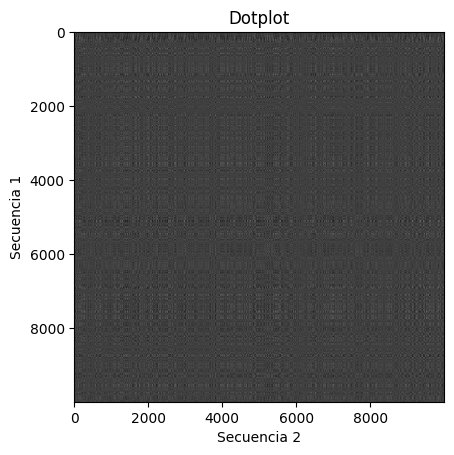

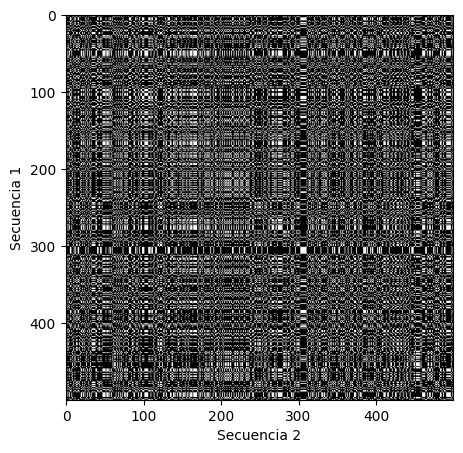

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
from Bio import SeqIO
import argparse
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import os

def merge_sequences_from_fasta(file_path):
    sequences = []  # List to store all sequences
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return "".join(sequences)

mod = SourceModule("""
__global__ void crear_dotplot(unsigned char *seq1, unsigned char *seq2, unsigned char *dotplot, int len1, int len2) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < len1 && y < len2) {
        if (seq1[x] == seq2[y]) {
            dotplot[x * len2 + y] = 1;
        }
    }
}
""")

crear_dotplot_cuda = mod.get_function("crear_dotplot")

def crear_dotplot(secuencia1, secuencia2):
    codigos_secuencia1 = np.frombuffer(secuencia1.encode(), dtype=np.uint8)
    codigos_secuencia2 = np.frombuffer(secuencia2.encode(), dtype=np.uint8)

    len1 = len(codigos_secuencia1)
    len2 = len(codigos_secuencia2)

    dotplot = np.zeros((len1, len2), dtype=np.uint8)

    threads_per_block = (32, 32, 1)
    blocks_per_grid_x = int(np.ceil(len1 / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(len2 / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, 1)

    try:
        crear_dotplot_cuda(
            drv.In(codigos_secuencia1),
            drv.In(codigos_secuencia2),
            drv.Out(dotplot),
            np.int32(len1),
            np.int32(len2),
            block=threads_per_block,
            grid=blocks_per_grid
        )
        drv.Context.synchronize()
    except drv.LogicError as e:
        print(f"Error en CUDA: {e}")
        raise

    return dotplot

def calcular_peso_matriz(matriz):
    bytes_matriz = sys.getsizeof(matriz)
    megabytes_matriz = bytes_matriz / (1024 ** 2)
    return megabytes_matriz

def draw_dotplot(matrix, fig_name='dotplot.svg'):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='gray', aspect='auto')
    plt.ylabel("Secuencia 1")
    plt.xlabel("Secuencia 2")
    plt.savefig(fig_name)

def filtrar_diagonales(dotplot_final):
    # Convertir la matriz dotplot_final a tipo de datos adecuado para CUDA
    dotplot_cuda = dotplot_final.astype(np.uint8)

    # Dimensiones de la matriz
    len1, len2 = dotplot_cuda.shape

    # Definir el código CUDA para el kernel que detecta líneas diagonales
    mod_diagonal = SourceModule("""
    __global__ void detectar_diagonales(unsigned char *dotplot, int len1, int len2) {
        int idx = blockIdx.x * blockDim.x + threadIdx.x;

        // Cada hilo verifica una posición diagonal en la matriz
        int x = idx;
        int y = 0;
        while (x < len1 && y < len2) {
            // Marcar la posición en el dotplot si se detecta una diagonal
            dotplot[x * len2 + y] = 255;  // Marcar con 255 para demostración, ajustar según sea necesario
            x++;
            y++;
        }
    }
    """)

    # Obtener el kernel CUDA
    kernel = mod_diagonal.get_function("detectar_diagonales")

    # Configuración de hilos y bloques
    threads_per_block = 256
    blocks_per_grid = (len1 + threads_per_block - 1) // threads_per_block

    try:
        # Llamar al kernel CUDA para detectar líneas diagonales
        kernel(drv.InOut(dotplot_cuda), np.int32(len1), np.int32(len2),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))
        drv.Context.synchronize()
    except drv.LogicError as e:
        print(f"Error en CUDA: {e}")
        raise

    # Convertir de nuevo a tipo np.uint8 si es necesario
    dotplot_final = dotplot_cuda.astype(np.uint8)

    return dotplot_final

if __name__ == '__main__':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    file1 = '/content/drive/MyDrive/Datos/E_coli.fna'
    file2 = '/content/drive/MyDrive/Datos/Salmonella.fna'
    limite = 10000
    output = '/content/drive/MyDrive/Datos/output.png'
    block_size = 10000

    if not os.path.exists(file1):
        raise FileNotFoundError(f"El archivo {file1} no existe.")
    if not os.path.exists(file2):
        raise FileNotFoundError(f"El archivo {file2} no existe.")

    print(f"Ruta del archivo 1: {file1}")
    print(f"Ruta del archivo 2: {file2}")

    parser = argparse.ArgumentParser(description='Mi Aplicación CUDA')
    parser.add_argument('--file1', type=str, help='Ruta del archivo 1')
    parser.add_argument('--file2', type=str, help='Ruta del archivo 2')
    parser.add_argument('--limite', type=int, help='Número máximo de bases a procesar')
    parser.add_argument('--output', type=str, help='Archivo de salida para la imagen')
    args, unknown = parser.parse_known_args()

    file1 = file1 if file1 else args.file1
    file2 = file2 if file2 else args.file2
    limite = limite if limite else args.limite
    output = output if output else args.output

    print(f"Procesando archivo 1: {file1}")
    print(f"Procesando archivo 2: {file2}")

    secuencia1 = merge_sequences_from_fasta(file1)[:limite]
    secuencia2 = merge_sequences_from_fasta(file2)[:limite]

    print(f"Tamaño de secuencia 1: {len(secuencia1)}")
    print(f"Tamaño de secuencia 2: {len(secuencia2)}")

    dotplot_final = np.zeros((len(secuencia1), len(secuencia2)), dtype=np.uint8)

    inicio_total = time.time()

    # Procesamiento de secuencias
    for i in range(0, len(secuencia1), block_size):
        for j in range(0, len(secuencia2), block_size):
            sec1_block = secuencia1[i:i + block_size]
            sec2_block = secuencia2[j:j + block_size]

            dotplot_block = crear_dotplot(sec1_block, sec2_block)

            dotplot_final[i:i + block_size, j:j + block_size] = dotplot_block

    fin_procesamiento_secuencias = time.time()

    # Filtrado de líneas diagonales
    inicio_filtrado = time.time()
    filtrar_diagonales(dotplot_final)
    fin_filtrado = time.time()

    # Tiempo total de ejecución
    fin_total = time.time()
    tiempo_total = fin_total - inicio_total

    tiempo_procesamiento_secuencias = fin_procesamiento_secuencias - inicio_total
    tiempo_filtrado = fin_filtrado - inicio_filtrado

    print(f"Tiempo total de ejecución: {tiempo_total} segundos")
    print(f"Tiempo de procesamiento de secuencias: {tiempo_procesamiento_secuencias} segundos")
    print(f"Tiempo de filtrado de diagonales: {tiempo_filtrado} segundos")

    tiempo_muerto = tiempo_total - tiempo_procesamiento_secuencias - tiempo_filtrado
    print(f"Tiempo muerto: {tiempo_muerto} segundos")

    preview_size = min(10000, len(secuencia1), len(secuencia2))
    dotplot_preview = dotplot_final[:preview_size, :preview_size]
    plt.imshow(dotplot_preview, cmap='gray')
    plt.title('Dotplot')
    plt.xlabel('Secuencia 2')
    plt.ylabel('Secuencia 1')
    plt.savefig(output)

    print("dot 500")
    draw_dotplot(dotplot_preview[:500, :500])

    print("El código se ejecutó en:", tiempo_total, "segundos")
    print("El tamaño de la matriz es:", dotplot_final.shape)
    print("La matriz resultado tiene un tamaño de " + str(calcular_peso_matriz(dotplot_final)) + " Mb")


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
from Bio import SeqIO
import argparse
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import os

def merge_sequences_from_fasta(file_path):
    sequences = []  # List to store all sequences
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return "".join(sequences)

mod = SourceModule("""
__global__ void crear_dotplot(unsigned char *seq1, unsigned char *seq2, unsigned char *dotplot, int len1, int len2) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < len1 && y < len2) {
        if (seq1[x] == seq2[y]) {
            dotplot[x * len2 + y] = 1;
        }
    }
}
""")

crear_dotplot_cuda = mod.get_function("crear_dotplot")

def crear_dotplot(secuencia1, secuencia2):
    codigos_secuencia1 = np.frombuffer(secuencia1.encode(), dtype=np.uint8)
    codigos_secuencia2 = np.frombuffer(secuencia2.encode(), dtype=np.uint8)

    len1 = len(codigos_secuencia1)
    len2 = len(codigos_secuencia2)

    dotplot = np.zeros((len1, len2), dtype=np.uint8)

    threads_per_block = (32, 32, 1)
    blocks_per_grid_x = int(np.ceil(len1 / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(len2 / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, 1)

    try:
        crear_dotplot_cuda(
            drv.In(codigos_secuencia1),
            drv.In(codigos_secuencia2),
            drv.Out(dotplot),
            np.int32(len1),
            np.int32(len2),
            block=threads_per_block,
            grid=blocks_per_grid
        )
        drv.Context.synchronize()
    except drv.LogicError as e:
        print(f"Error en CUDA: {e}")
        raise

    return dotplot

def calcular_peso_matriz(matriz):
    bytes_matriz = sys.getsizeof(matriz)
    megabytes_matriz = bytes_matriz / (1024 ** 2)
    return megabytes_matriz

def draw_dotplot(matrix, fig_name='dotplot.svg'):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='gray', aspect='auto')
    plt.ylabel("Secuencia 1")
    plt.xlabel("Secuencia 2")
    plt.savefig(fig_name)

def filtrar_diagonales(dotplot_final):
    dotplot_cuda = dotplot_final.astype(np.uint8)

    len1, len2 = dotplot_cuda.shape

    mod_diagonal = SourceModule("""
    __global__ void detectar_diagonales(unsigned char *dotplot, int len1, int len2) {
        int idx = blockIdx.x * blockDim.x + threadIdx.x;

        // Cada hilo verifica una posición diagonal en la matriz
        int x = idx;
        int y = idx;
        while (x < len1 && y < len2) {
            // Marcar la posición en el dotplot si se detecta una diagonal
            dotplot[x * len2 + y] = 255;  // Marcar con 255 para demostración, ajustar según sea necesario
            x++;
            y++;
        }
    }
    """)

    kernel = mod_diagonal.get_function("detectar_diagonales")

    threads_per_block = 256
    blocks_per_grid = (min(len1, len2) + threads_per_block - 1) // threads_per_block

    try:
        kernel(drv.InOut(dotplot_cuda), np.int32(len1), np.int32(len2),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))
        drv.Context.synchronize()
    except drv.LogicError as e:
        print(f"Error en CUDA: {e}")
        raise

    dotplot_final = dotplot_cuda.astype(np.uint8)

    return dotplot_final

if __name__ == '__main__':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    file1 = '/content/drive/MyDrive/Datos/E_coli.fna'
    file2 = '/content/drive/MyDrive/Datos/Salmonella.fna'
    limite = 10000
    output = '/content/drive/MyDrive/Datos/output.png'
    block_size = 10000

    if not os.path.exists(file1):
        raise FileNotFoundError(f"El archivo {file1} no existe.")
    if not os.path.exists(file2):
        raise FileNotFoundError(f"El archivo {file2} no existe.")

    print(f"Ruta del archivo 1: {file1}")
    print(f"Ruta del archivo 2: {file2}")

    parser = argparse.ArgumentParser(description='Mi Aplicación CUDA')
    parser.add_argument('--file1', type=str, help='Ruta del archivo 1')
    parser.add_argument('--file2', type=str, help='Ruta del archivo 2')
    parser.add_argument('--limite', type=int, help='Número máximo de bases a procesar')
    parser.add_argument('--output', type=str, help='Archivo de salida para la imagen')
    args, unknown = parser.parse_known_args()

    file1 = file1 if file1 else args.file1
    file2 = file2 if file2 else args.file2
    limite = limite if limite else args.limite
    output = output if output else args.output

    print(f"Procesando archivo 1: {file1}")
    print(f"Procesando archivo 2: {file2}")

    secuencia1 = merge_sequences_from_fasta(file1)[:limite]
    secuencia2 = merge_sequences_from_fasta(file2)[:limite]

    print(f"Tamaño de secuencia 1: {len(secuencia1)}")
    print(f"Tamaño de secuencia 2: {len(secuencia2)}")

    dotplot_final = np.zeros((len(secuencia1), len(secuencia2)), dtype=np.uint8)

    inicio_total = time.time()

    # Procesamiento de secuencias
    for i in range(0, len(secuencia1), block_size):
        for j in range(0, len(secuencia2), block_size):
            sec1_block = secuencia1[i:i + block_size]
            sec2_block = secuencia2[j:j + block_size]

            dotplot_block = crear_dotplot(sec1_block, sec2_block)

            dotplot_final[i:i + block_size, j:j + block_size] = dotplot_block

    fin_procesamiento_secuencias = time.time()

    # Filtrado de líneas diagonales
    inicio_filtrado = time.time()
    dotplot_final_filtrado = filtrar_diagonales(dotplot_final)
    fin_filtrado = time.time()

    # Tiempo total de ejecución
    fin_total = time.time()
    tiempo_total = fin_total - inicio_total

    tiempo_procesamiento_secuencias = fin_procesamiento_secuencias - inicio_total
    tiempo_filtrado = fin_filtrado - inicio_filtrado

    print(f"Tiempo total de ejecución: {tiempo_total} segundos")
    print(f"Tiempo de procesamiento de secuencias: {tiempo_procesamiento_secuencias} segundos")
    print(f"Tiempo de filtrado de diagonales: {tiempo_filtrado} segundos")

    tiempo_muerto = tiempo_total - tiempo_procesamiento_secuencias - tiempo_filtrado
    print(f"Tiempo muerto: {tiempo_muerto} segundos")

    preview_size = min(10000, len(secuencia1), len(secuencia2))
    dotplot_preview = dotplot_final_filtrado[:preview_size, :preview_size]

    plt.imshow(dotplot_preview, cmap='gray', aspect='auto')
    plt.title('Dotplot Filtrado con Diagonales')
    plt.xlabel('Secuencia 2')
    plt.ylabel('Secuencia 1')
    plt.savefig(output)

    plt.show()

    print("El código se ejecutó en:", tiempo_total, "segundos")
    print("El tamaño de la matriz es:", dotplot_final.shape)
    print("La matriz resultado tiene un tamaño de " + str(calcular_peso_matriz(dotplot_final)) + " Mb")


ModuleNotFoundError: No module named 'Bio'